In [1]:
# Import required libraries
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from matplotlib.ticker import FormatStrFormatter


## Import ASHRAE Thermal Comfort Database 2

In [2]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

<ipython-input-2-c67988f7a35f>:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [3]:
# Merge building metadata and measurement data
df_data = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_data.building_id.unique()))
print('Total records:', len(df_data))

Total buildings: 809
Total records: 109033


### Data cleaning

In [4]:
# Merge two outdoor air temperature columns as a new column
df_data.loc[:, 't_out_combined'] = df_data.loc[:, 't_out_isd'].fillna(df_data.loc[:, 't_out'])
# Remove the two outdoor air temperature columns
df_data = df_data.drop(columns=['t_out_isd', 't_out'])

# Keep rows that simultaneously have data for all variables in cols 
def keep_rows(df, cols):
    df_new = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_new['building_id'].unique()), cols)
    print(f'Qualified records:', len(df_new))
    return df_new

In [5]:
cols = ['t_out_combined', 'top', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 553 ['t_out_combined', 'top', 'thermal_sensation']
Qualified records: 38467


## regressing thermal sensation votes against thermal acceptability

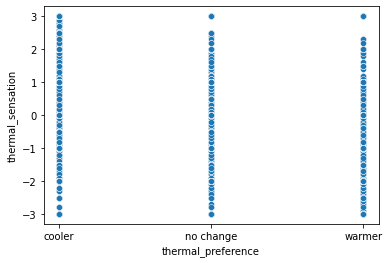

In [11]:
# scatter plot thermal sensation and thermal acceptability using df_data
sns.scatterplot(x='thermal_preference', y='thermal_sensation', data=df_data)

# Title and labels
# plt.title('Scatter plot of Thermal Sensation vs Thermal Acceptability')
# plt.xlabel('Thermal Sensation')
# plt.ylabel('Thermal Acceptability')

# Display the plot
plt.show()


## Estimation result on the first building in the dataset

In [12]:
# neutral temepratuer calculation example
df_data_1bldg = df_data[df_data['building_id'] == 1]
df_data_1bldg.head()

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833


### linear regression method (a)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_6793/2486365771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])


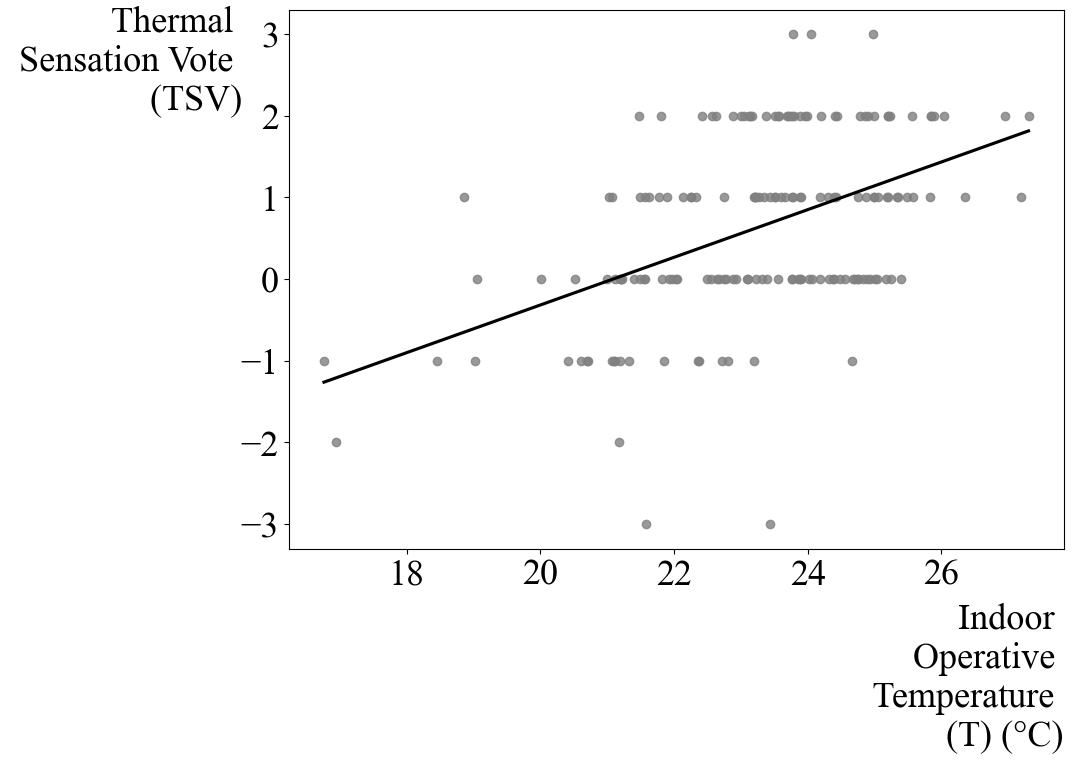

Neutral temperature is 21.1 degree Celsius.
80 percent acceptable temperature range is (18.2 ~ 24.0) degree Celsius.
90 percent acceptable temperature range is (19.4 ~ 22.8) degree Celsius.
p value: 1.2974572985470425e-10
                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.30e-10
Time:                        06:29:40   Log-Likelihood:                -237.80
No. Observations:                 169   AIC:                             479.6
Df Residuals:                     167   BIC:                             485.9
Df Model:                           1                                         
Covariance Type:            nonrobust                              

In [167]:

# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='thermal_sensation ~ top', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'}, ci=None)
plt.xlabel('Indoor \n Operative \n Temperature \n (T) (°C)', fontsize=26)
plt.ylabel('Thermal \n Sensation Vote \n (TSV)', rotation=0, fontsize=26)
# plt.title('Regress thermal sensation votes on indoor temperature')
# change the font to sen-serif Times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.06, 0.8)
# alighn label right in the text box
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=26)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=26)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['top'] < 0.05:
    a = lm_result.params['top']
    b = lm_result.params['Intercept']
    neutral_temp = -b / a
    temp80_up = (0.85-b)/a
    temp80_low = (-0.85-b)/a
    temp90_up = (0.5-b)/a
    temp90_low = (-0.5-b)/a
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))
else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['top'])
print(lm_result.summary())


### linear regression method (b)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_6793/2781437288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])


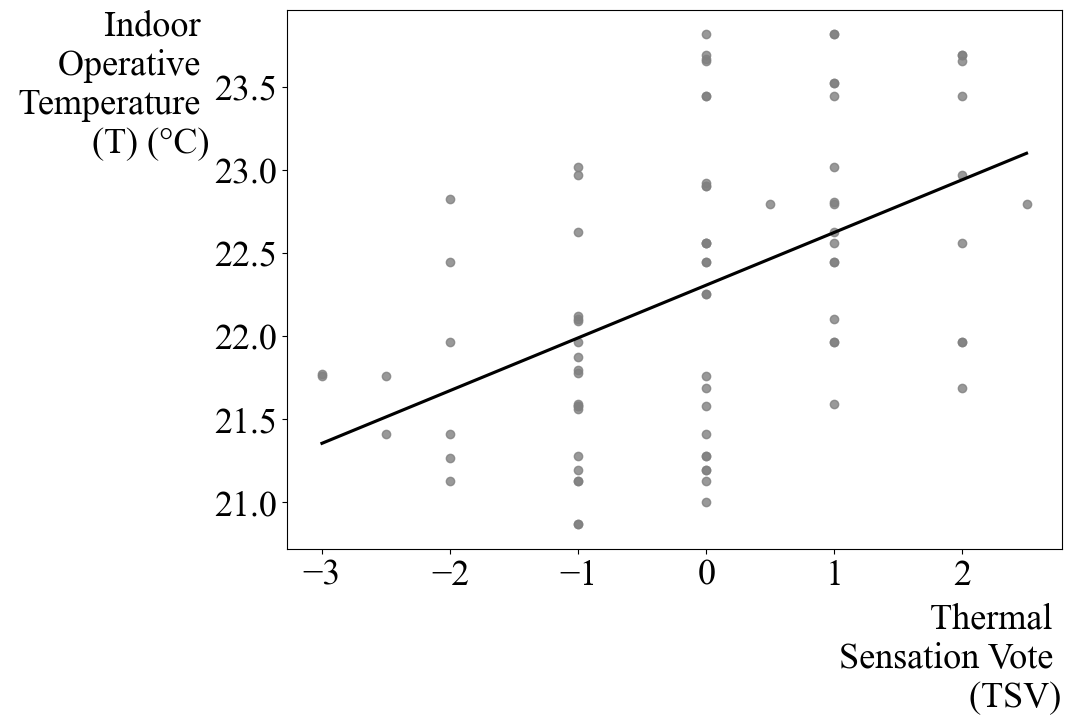

Neutral temperature is 22.3 degree Celsius.
80 percent acceptable temperature range is (22.0 ~ 22.6) degree Celsius.
90 percent acceptable temperature range is (22.1 ~ 22.5) degree Celsius.
p value: 6.069010901848069e-06
                            OLS Regression Results                            
Dep. Variable:                    top   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     23.44
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           6.07e-06
Time:                        06:29:20   Log-Likelihood:                -93.485
No. Observations:                  83   AIC:                             191.0
Df Residuals:                      81   BIC:                             195.8
Df Model:                           1                                         
Covariance Type:            nonrobust                               

In [165]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='top ~ thermal_sensation', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])
# plot the regression line, don't show the confidence interval
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_1bldg, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'}, ci=None)

plt.xlabel('Thermal \n Sensation Vote \n (TSV)', rotation=0, fontsize=26)
plt.ylabel('Indoor \n Operative \n Temperature \n (T) (°C)', rotation=0, fontsize=26)

# plt.title('Regress thermal sensation votes on indoor temperature')
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.72)
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=26)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=26)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    neutral_temp = b
    temp80_up = 0.85*a + b
    temp80_low = (-0.85)*a + b
    temp90_up = 0.5*a + b
    temp90_low = (-0.5)*a + b
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))

else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['thermal_sensation'])
print(lm_result.summary())

### two methods have the same pearson correlation coefficient

In [144]:
# calculate pearson correlation coefficient
df_data_1bldg[['top', 'thermal_sensation']].corr()

,top,thermal_sensation
top,1.000000,0.468746
thermal_sensation,0.468746,1.000000


## Estimation results on every building in the dataset

### Two linear regression functions

In [145]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = lm_result.params['top']
            b = lm_result.params['Intercept']
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            a = lm_result.params['thermal_sensation']
            b = lm_result.params['Intercept']
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### estimation for all buildings

In [146]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office


In [147]:
# calculate all temperature values for each building
columns_name = ['slope', 'intercept', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

# calculate the mean of the absolute difference between t_80_up_a and t_80_low_a
df_bldg['t_80_diff_a'] = df_bldg['t_80_up_a'] - df_bldg['t_80_low_a']
df_bldg['t_80_diff_b'] = df_bldg['t_80_up_b'] - df_bldg['t_80_low_b']

df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office,0.291819,0.752942,-6.154552,22.767420,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,5.825536,1.280002
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office,0.706530,0.317700,-15.816544,22.306879,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,2.406125,0.540090
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office,NaN,0.013208,NaN,23.174896,NaN,23.174896,NaN,23.186122,NaN,23.163670,NaN,0.022453
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office,0.504547,0.495382,-11.992110,23.922257,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,3.369362,0.842150
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office,NaN,0.137435,NaN,22.104007,NaN,22.104007,NaN,22.220827,NaN,21.987187,NaN,0.233640


In [148]:
# calcualte MSE for each building
for i, row in df_bldg.iterrows():
    # Step 1: Filter df_data for the building
    building_data = df_data[df_data['building_id'] == row['building_id']]
    
    # Step 2: Extract 'thermal_sensation' and 'top' columns
    # y_true = building_data['thermal_sensation']
    tsv = building_data['thermal_sensation']
    top = building_data['top']
    
    # Step 3: Calculate predicted values for method A
    if pd.notna(row['slope_a']) and pd.notna(row['intercept_a']):
        y_pred_a = row['slope_a'] * top + row['intercept_a']
        
        # Step 4: Calculate MSE for method A
        mse_a = mean_squared_error(tsv, y_pred_a)
    else:
        mse_a = None
    
    # Step 5: Repeat steps 3-4 for method B
    if pd.notna(row['slope_b']) and pd.notna(row['intercept_b']):
        y_pred_b = row['slope_b'] * tsv + row['intercept_b']
        
        # Step 6: Calculate MSE for method B
        mse_b = mean_squared_error(top, y_pred_b)
    else:
        mse_b = None
    
    # Store the MSE values in df_bldg
    df_bldg.at[i, 'mse_a'] = mse_a
    df_bldg.at[i, 'mse_b'] = mse_b

# Now df_bldg has two new columns 'mse_a' and 'mse_b' containing the MSE values for method A and B for each building.


In [150]:
# sum mse_a and mse_b for all buildings that achieve statistical significance
print(df_bldg['mse_a'].sum())
print(df_bldg['mse_b'].sum())

162.49750742326728
1201.654470708199


### skip

In [65]:
### a temperory neutral temperature calculation furnction for including non statistical significant buildings
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        a = lm_result.params['top']
        b = lm_result.params['Intercept']
        n_t = -b / a
        t_80_up = (0.85-b)/a
        t_80_low = (-0.85-b)/a
        t_90_up = (0.5-b)/a
        t_90_low = (-0.5-b)/a
        return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        a = lm_result.params['thermal_sensation']
        b = lm_result.params['Intercept']
        n_t = b
        t_80_up = 0.85*a + b
        t_80_low = (-0.85)*a + b
        t_90_up = 0.5*a + b
        t_90_low = (-0.5)*a + b
        return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
    except (ValueError, TypeError):
        return np.nan

In [71]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office


In [72]:
# calculate all temperature values for each building
columns_name = ['slope', 'intercept', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:9: RuntimeWarning: invalid value encountered in scalar divide
  n_t = -b / a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  t_80_up = (0.85-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  t_80_low = (-0.85-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  t_90_up = (0.5-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  t_90_low = (-0.5-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:9: RuntimeWarning: invalid value encountered in scalar divide
  n_t = -b / a
/var/folders/v0/03v41t

In [73]:
df_bldg

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office,0.291819,0.752942,-6.154552,22.767420,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office,0.706530,0.317700,-15.816544,22.306879,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office,0.047597,0.013208,-0.850281,23.174896,17.864050,23.174896,35.722188,23.186122,0.005913,23.163670
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office,0.504547,0.495382,-11.992110,23.922257,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office,0.161458,0.137435,-3.630748,22.104007,22.487246,22.104007,27.751771,22.220827,17.222722,21.987187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,737,24.316162,25.010101,28.469928,99,Air Conditioned,office,0.079583,0.279189,-2.727761,25.215968,34.275529,25.215968,44.956156,25.453278,23.594902,24.978657
549,738,24.202332,24.372798,28.905322,387,Air Conditioned,office,0.121583,0.087743,-3.870064,24.452358,31.830522,24.452358,38.821606,24.526939,24.839438,24.377776
550,739,22.957143,23.000000,25.815476,56,Air Conditioned,office,0.133929,0.331579,-4.794643,23.568421,35.800000,23.568421,42.146667,23.850263,29.453333,23.286579
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,classroom,0.232627,0.318970,-4.690074,22.809739,20.161369,22.809739,23.815291,23.080864,16.507447,22.538615


In [74]:
# calcualte MSE for each building
for i, row in df_bldg.iterrows():
    # Step 1: Filter df_data for the building
    building_data = df_data[df_data['building_id'] == row['building_id']]
    
    # Step 2: Extract 'thermal_sensation' and 'top' columns
    # y_true = building_data['thermal_sensation']
    tsv = building_data['thermal_sensation']
    top = building_data['top']
    
    # Step 3: Calculate predicted values for method A
    if pd.notna(row['slope_a']) and pd.notna(row['intercept_a']):
        y_pred_a = row['slope_a'] * top + row['intercept_a']
        
        # Step 4: Calculate MSE for method A
        mse_a = mean_squared_error(tsv, y_pred_a)
    else:
        mse_a = None
    
    # Step 5: Repeat steps 3-4 for method B
    if pd.notna(row['slope_b']) and pd.notna(row['intercept_b']):
        y_pred_b = row['slope_b'] * tsv + row['intercept_b']
        
        # Step 6: Calculate MSE for method B
        mse_b = mean_squared_error(top, y_pred_b)
    else:
        mse_b = None
    
    # Store the MSE values in df_bldg
    df_bldg.at[i, 'mse_a'] = mse_a
    df_bldg.at[i, 'mse_b'] = mse_b

# Now df_bldg has two new columns 'mse_a' and 'mse_b' containing the MSE values for method A and B for each building.


In [75]:
# sum mse_a and mse_b for all buildings including non statistical significance
print(df_bldg['mse_a'].sum())
print(df_bldg['mse_b'].sum())

319.3962620488572
1215.1328595970879


### does a negative relationship reasonable?

In [151]:
# identify less than 0 values in slope_a and slope_b
# df_bldg[df_bldg['slope_a'] < 0]
# df_bldg[df_bldg['slope_b'] < 0]


In [152]:
# create a buliding id list for buildings with negative slope_a or slope_b
bldg_id_neg = df_bldg[(df_bldg['slope_a'] < 0) | (df_bldg['slope_b'] < 0)]['building_id'].tolist()
# remove the buildings of bldg_id_neg from df_bldg
df_bldg = df_bldg[~df_bldg['building_id'].isin(bldg_id_neg)].copy()

In [153]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]

print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

df_bldg_ac_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 210
number of naturally ventilated buildings that have statistical significant neutral temperature: 70
number of air conditioned buildings that have statistical significant neutral temperature: 85


In [154]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]

print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))

df_bldg_ac_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_b))

df_bldg_re_b = df_bldg_sig_b[df_bldg_sig_b['building_type'] == 'multifamily housing']
print('number of multi-family buildings that have statistical significant neutral temperature:', len(df_bldg_re_b))


regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 421
number of naturally ventilated buildings that have statistical significant neutral temperature: 151
number of air conditioned buildings that have statistical significant neutral temperature: 146
number of multi-family buildings that have statistical significant neutral temperature: 196


## neutral temeprature comparasion (skip)

n_t_a
count    210.000000
mean      24.427157
std        2.847115
min       19.021124
25%       22.575175
50%       23.878357
75%       25.981671
max       33.242804
Name: n_t_a, dtype: float64
n_t_b
count    421.000000
mean      25.021332
std        4.270422
min        6.316000
25%       22.674187
50%       24.027941
75%       28.595637
max       35.490000
Name: n_t_b, dtype: float64


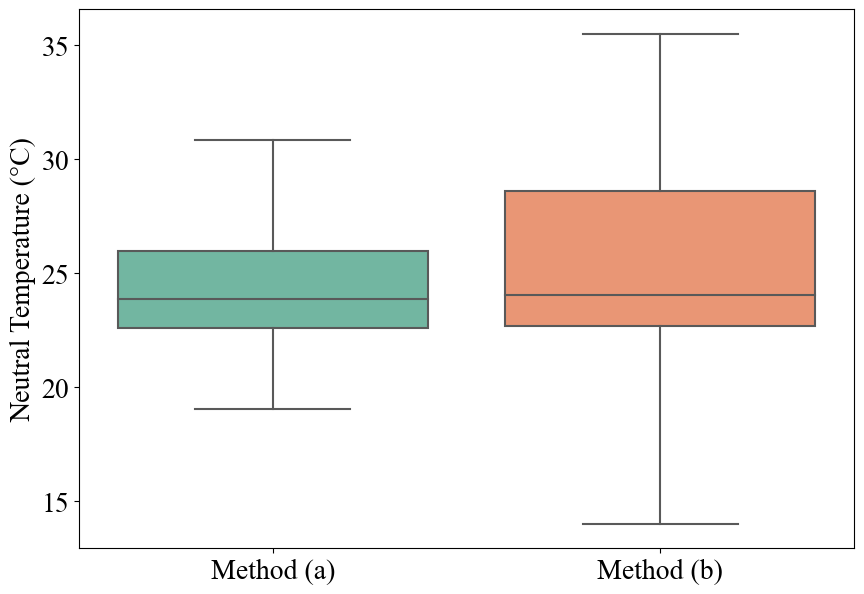

In [19]:
# boxplot of n_t_a in df_bldg_sig_a and n_t_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['n_t_a'], df_bldg_sig_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_sig_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_sig_b['n_t_b'].describe())

plt.ylabel('Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    70.000000
mean     24.289955
std       3.147114
min      19.021124
25%      22.052439
50%      23.966312
75%      26.418541
max      33.242804
Name: n_t_a, dtype: float64
n_t_b
count    151.000000
mean      26.844239
std        4.591386
min        6.316000
25%       23.911761
50%       27.913905
75%       30.269705
max       35.490000
Name: n_t_b, dtype: float64


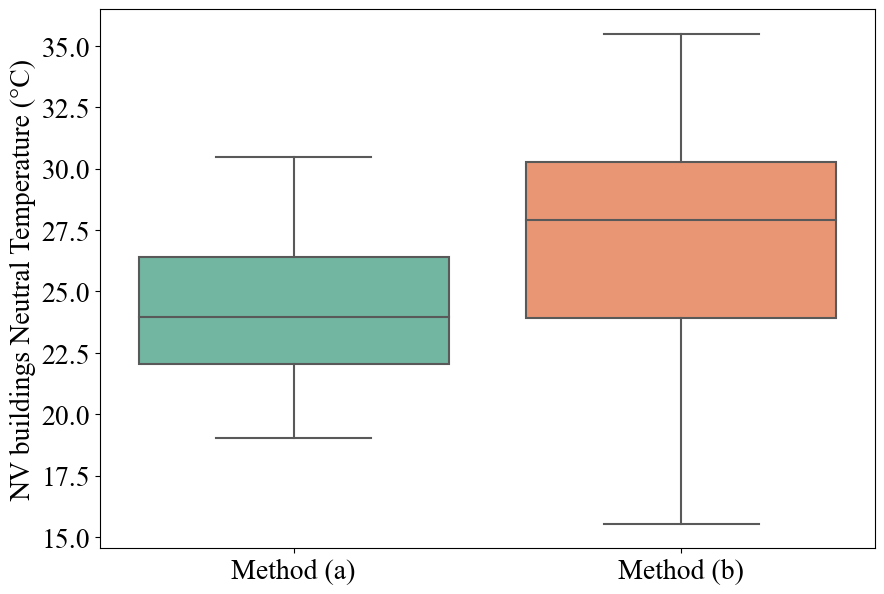

In [20]:
# NV buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_nv_a['n_t_a'], df_bldg_nv_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_nv_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_nv_b['n_t_b'].describe())

plt.ylabel('NV buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    85.000000
mean     23.926550
std       1.484819
min      21.535360
25%      22.979321
50%      23.860139
75%      24.345989
max      31.830522
Name: n_t_a, dtype: float64
n_t_b
count    146.000000
mean      23.194457
std        1.716078
min       12.775000
25%       22.685217
50%       23.335666
75%       23.909456
max       27.763548
Name: n_t_b, dtype: float64


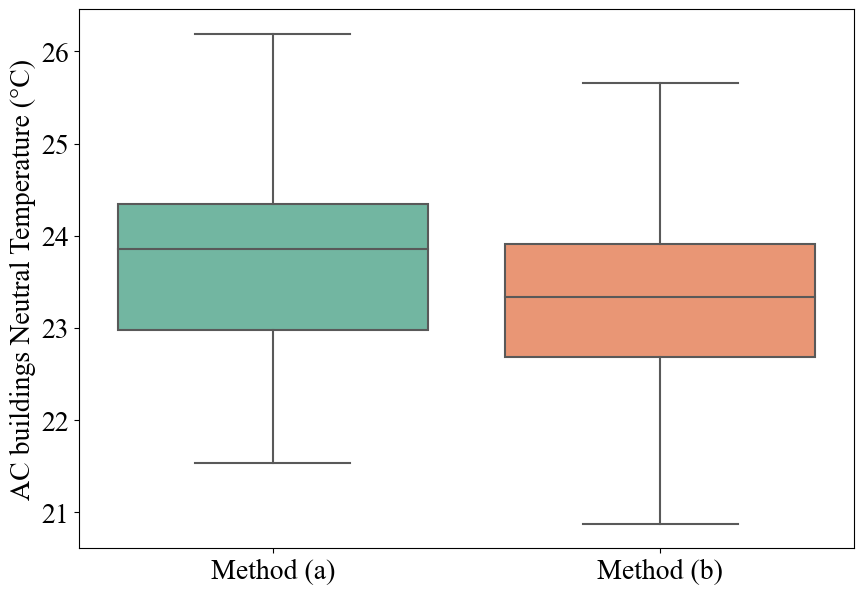

In [21]:
# AC buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_ac_a['n_t_a'], df_bldg_ac_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_ac_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_ac_b['n_t_b'].describe())

plt.ylabel('AC buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

acceptable temeprature range comparasion

t_80_up_a
count    210.000000
mean      27.668742
std        3.412919
min       21.911428
25%       25.163584
50%       26.524534
75%       29.920540
max       38.821606
Name: t_80_up_a, dtype: float64
t_80_up_b
count    421.000000
mean      25.844303
std        4.051518
min       13.100000
25%       23.157944
50%       24.749994
75%       29.516667
max       35.490000
Name: t_80_up_b, dtype: float64


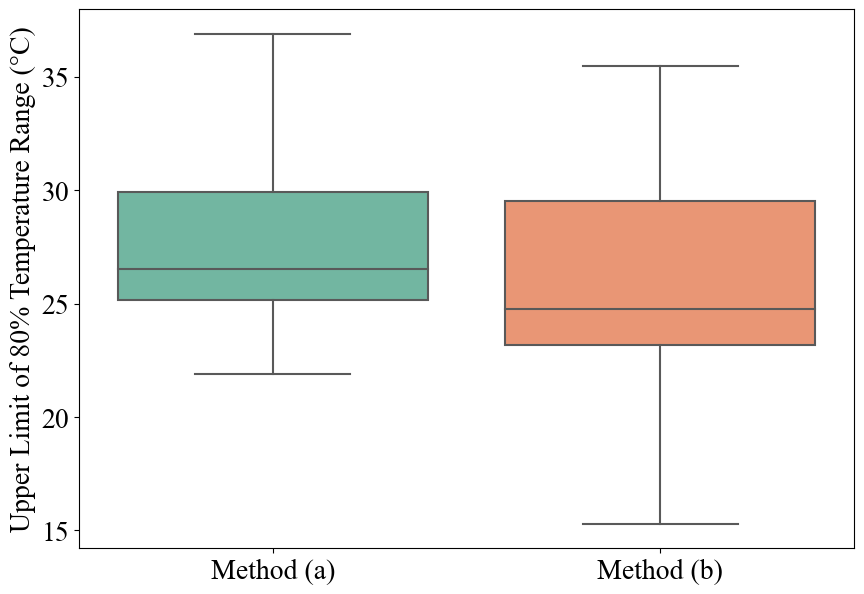

In [22]:
# boxplot of t_80_up_a in df_bldg_sig_a and t_80_up_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_up_a'], df_bldg_sig_b['t_80_up_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_up_a')
print(df_bldg_sig_a['t_80_up_a'].describe())
print('t_80_up_b')
print(df_bldg_sig_b['t_80_up_b'].describe())

plt.ylabel('Upper Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_low_a
count    210.000000
mean      21.185572
std        3.862306
min        4.465876
25%       19.191383
50%       21.601877
75%       23.125084
max       29.146479
Name: t_80_low_a, dtype: float64
t_80_low_b
count    421.000000
mean      24.198361
std        4.912291
min       -4.421200
25%       22.101421
50%       23.658147
75%       27.673333
max       35.490000
Name: t_80_low_b, dtype: float64


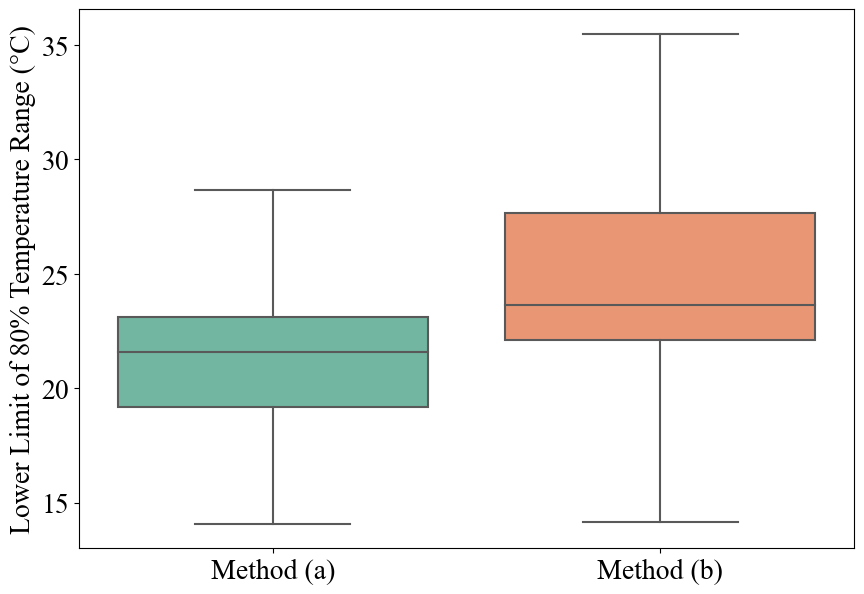

In [23]:
# boxplot of t_80_low_a in df_bldg_sig_a and t_80_low_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_low_a'], df_bldg_sig_b['t_80_low_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_low_a')
print(df_bldg_sig_a['t_80_low_a'].describe())
print('t_80_low_b')
print(df_bldg_sig_b['t_80_low_b'].describe())

plt.ylabel('Lower Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_diff_a
count    210.000000
mean       6.483170
std        4.550449
min        0.034000
25%        3.419248
50%        5.435545
75%        8.369759
max       29.110494
Name: t_80_diff_a, dtype: float64
t_80_diff_b
count    421.000000
mean       1.645942
std        2.853907
min        0.000000
25%        0.212053
50%        0.694763
75%        2.078316
max       26.422250
Name: t_80_diff_b, dtype: float64


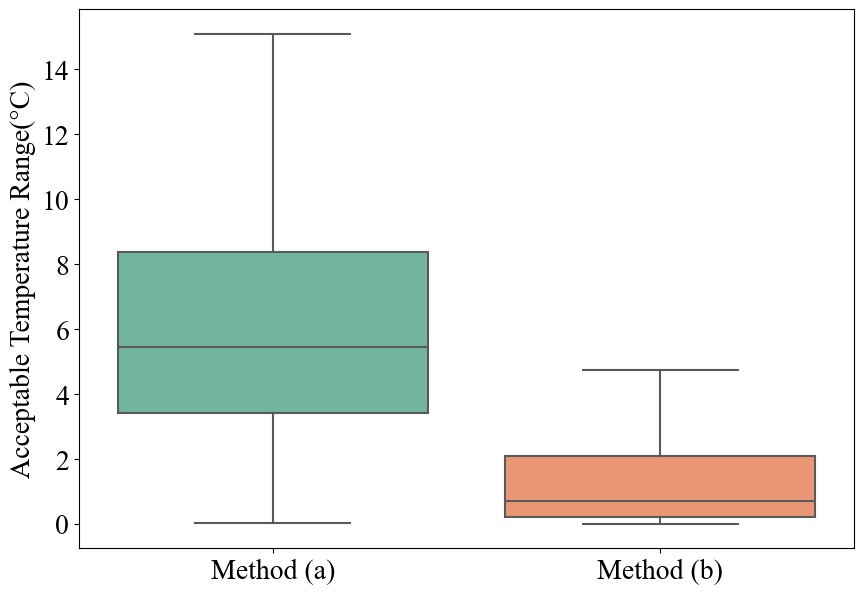

In [24]:
# boxplot of t_80_diff_a in df_bldg_sig_a and t_80_diff_b in df_bldg_sig_b, don't show outliers
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_diff_a'], df_bldg_sig_b['t_80_diff_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_diff_a')
print(df_bldg_sig_a['t_80_diff_a'].describe())
print('t_80_diff_b')
print(df_bldg_sig_b['t_80_diff_b'].describe())

plt.ylabel('Acceptable Temperature Range(°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()


In [25]:
# how many buildings have a negative coefficient for the regression of thermal sensation against temperature


## Adaptive comfort model (natural ventilated buildings)

In [155]:
# Weighted regression function
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    # print p value of slope
    print('the p value of slope is {:.3f}'.format(model.pvalues[1]))
    print('the weigted regression fitted line slope (a) a is {:.2f}'.format(slope))
    print('the weigted regression fitted line intercept (b) is {:.2f}'.format(intercept))
    return intercept, slope

In [156]:
print("neutral temperature line")
weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], df_bldg_nv_a['records'])

neutral temperature line
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.29
the weigted regression fitted line intercept (b) is 18.00


(17.998538214485958, 0.2909233476943429)

method a

In [157]:
middle_a_intercept, middle_a_slope = weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], df_bldg_nv_a['records'])
up_a_intercept, up_a_slope = weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_up_a'], df_bldg_nv_a['records'])
low_a_intercept, low_a_slope= weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_low_a'], df_bldg_nv_a['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.29
the weigted regression fitted line intercept (b) is 18.00
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.25
the weigted regression fitted line intercept (b) is 22.76
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.33
the weigted regression fitted line intercept (b) is 13.24


In [158]:
# calculate the average value of t_80_diff_a and t_80_diff_b
range_a = df_bldg_nv_a['t_80_diff_a'].mean()
print(range_a)
range_b = df_bldg_nv_a['t_80_diff_b'].mean()
print(range_b)

7.308879792901509
1.9223362385548322


(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

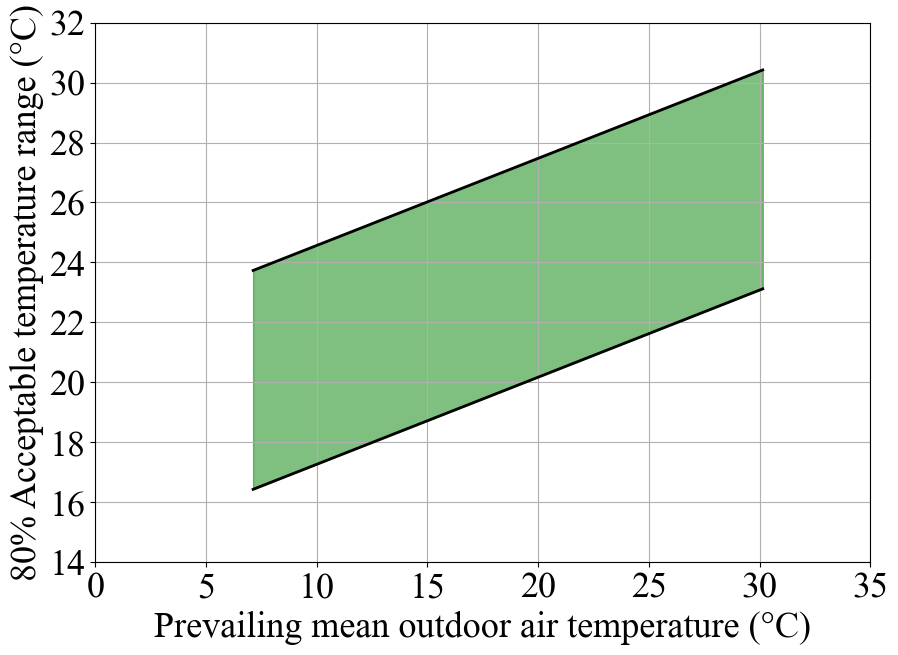

In [162]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_a_slope*t_out_combined+middle_a_intercept+range_a/2)[sort_index]
low_line = (middle_a_slope*t_out_combined+middle_a_intercept-range_a/2)[sort_index]


# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='green', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80 temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
# plt.title('Naturally ventilated buildings using method a', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)


(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

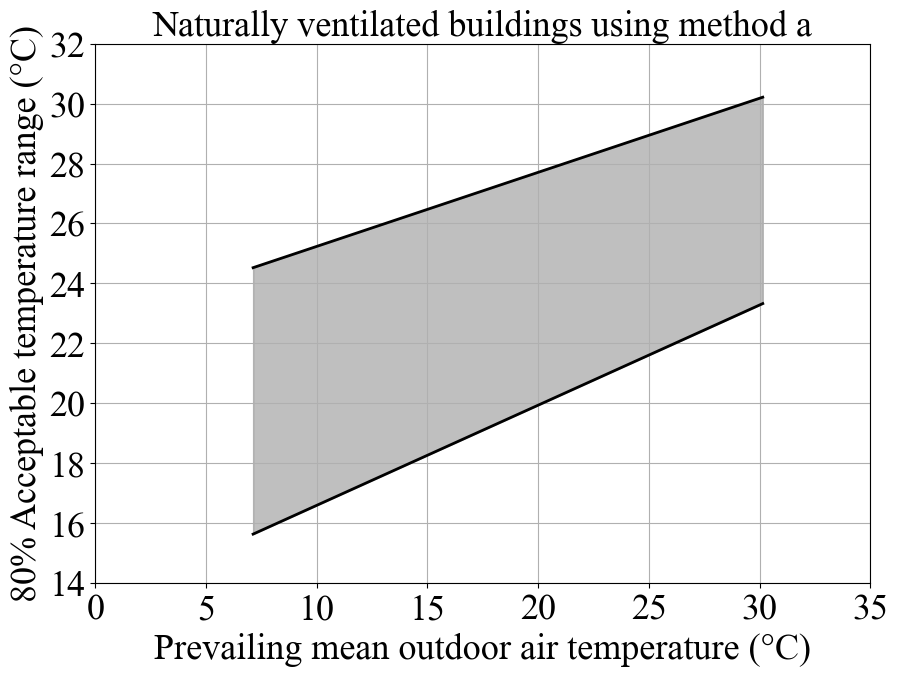

In [160]:
# plot two lines, one with the up_a_slope and up_a_intercept, and another with the low_a_slope and low_a_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_a_slope*t_out_combined + up_a_intercept)[sort_index]
low_line = (low_a_slope*t_out_combined + low_a_intercept)[sort_index]


# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, color='black', linewidth=2)
# plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_a_slope*t_out_combined+low_a_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, low_a_slope*t_out_combined+low_a_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Naturally ventilated buildings using method a', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)


In [161]:
# calculate mean squared error (MSE) for the regression line
def mse(x, y, intercept, slope):
    y_pred = slope*x + intercept
    mse = np.mean((y-y_pred)**2)
    return mse


#mse

In [37]:
mse(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], middle_a_intercept, middle_a_slope)

5.193135275034498

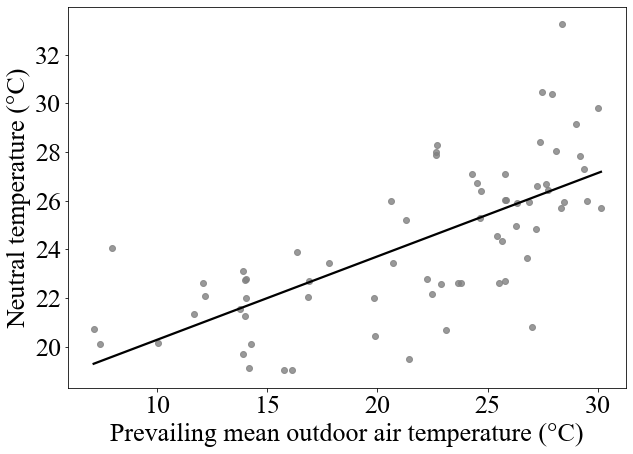

In [38]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_a', data=df_bldg_nv_a, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'}, ci=None)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("Neutral temperature (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'

method b

In [39]:
middle_b_intercept, middle_b_slope = weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['n_t_b'], df_bldg_nv_b['records'])
up_b_intercept, up_b_slope = weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_up_b'], df_bldg_nv_b['records'])
low_b_intercept, low_b_slope= weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_low_b'], df_bldg_nv_b['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.44
the weigted regression fitted line intercept (b) is 16.21
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.46
the weigted regression fitted line intercept (b) is 16.47
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.42
the weigted regression fitted line intercept (b) is 15.95


(14.0, 32.0)

<Figure size 720x504 with 0 Axes>

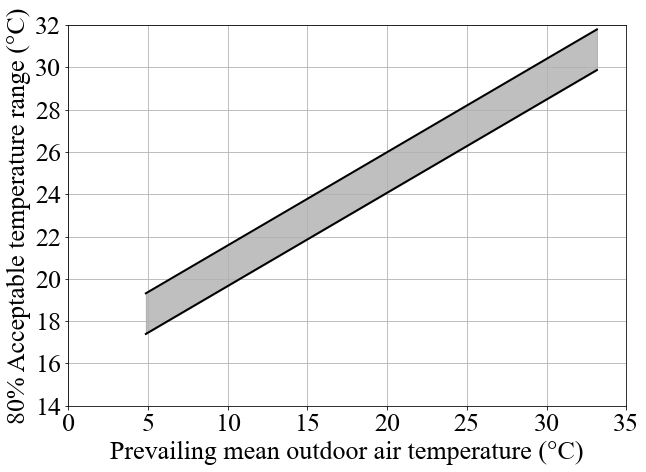

In [100]:
# plot the same diagram as ACM
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_b_slope*t_out_combined+middle_b_intercept+range_b/2)[sort_index]
low_line = (middle_b_slope*t_out_combined+middle_b_intercept-range_b/2)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='black', linewidth=2)

plt.fill_between(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

# plt.title('naturally ventialted buildings using method b', fontsize=26)
plt.grid(True)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



(14.0, 32.0)

<Figure size 720x504 with 0 Axes>

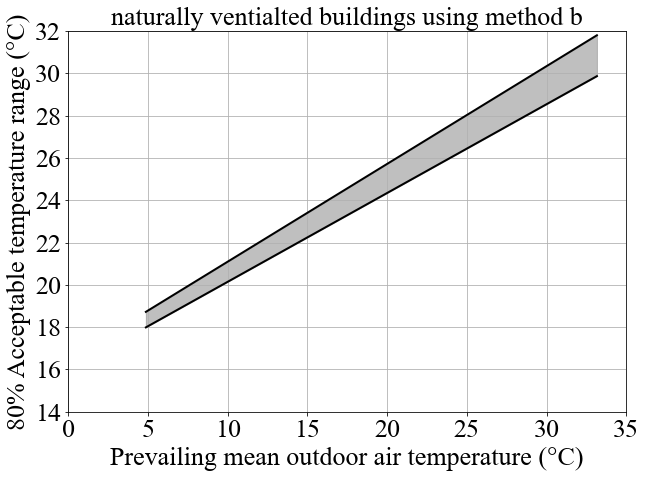

In [98]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
# plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.title('naturally ventialted buildings using method b', fontsize=26)
plt.grid(True)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



#mse

In [41]:
mse(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['n_t_b'], middle_b_intercept, middle_b_slope)

10.585650536499191

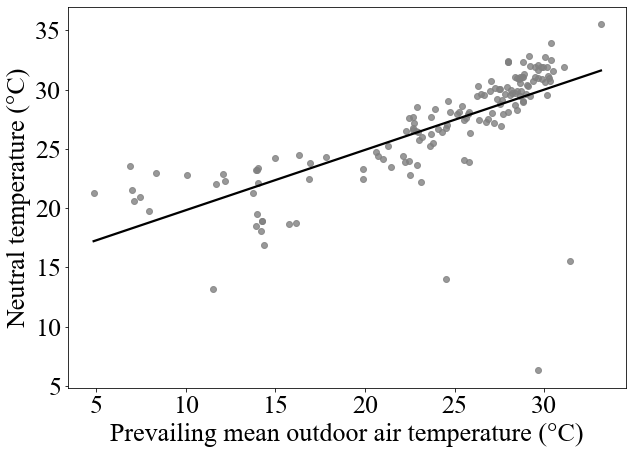

In [42]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_b', data=df_bldg_nv_b, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'}, ci=None)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("Neutral temperature (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'


Adaptive model in air conditioned buildings, and residential buildings using method b

The range should be larger

(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

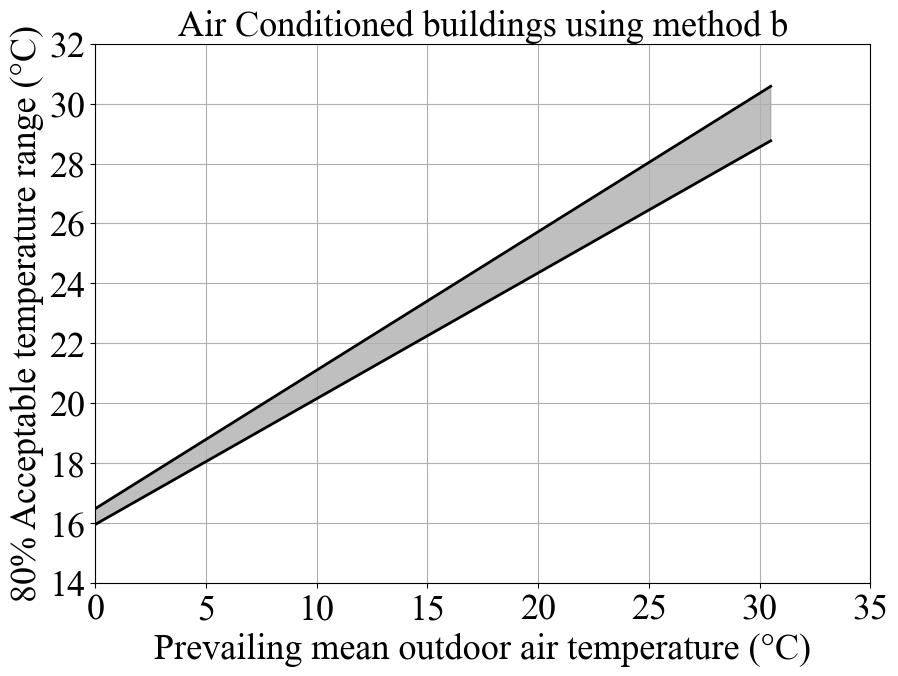

In [34]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_ac_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'
# title is 'Air Conditioned buildings'


# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Air Conditioned buildings using method b', fontsize=26)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

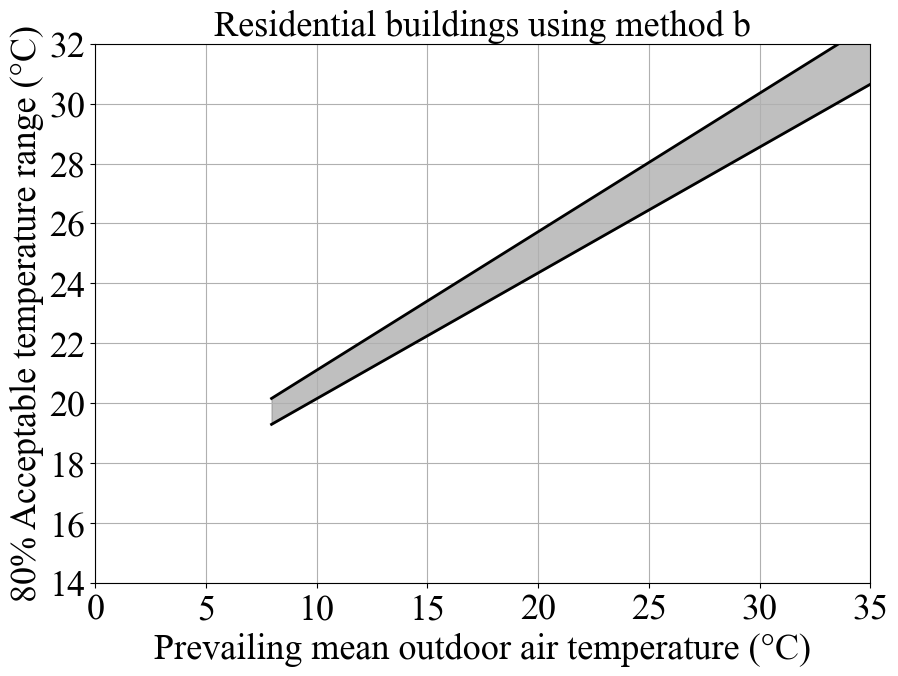

In [35]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_re_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Residential buildings using method b', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



Try SET

In [36]:
cols = ['t_out_combined', 'set', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 518 ['t_out_combined', 'set', 'thermal_sensation']
Qualified records: 26307


In [37]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ set', data=bldg).fit()
        slope = lm_result.params['set']
        # check whether the slope is significant
        if lm_result.pvalues['set'] < 0.05:
            a = lm_result.params['set']
            b = lm_result.params['Intercept']
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='set ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            a = lm_result.params['thermal_sensation']
            b = lm_result.params['Intercept']
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

In [38]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'set', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,set,t_out_combined,records,cooling_type,building_type
0,1,23.171127,25.454225,15.560695,170,Mixed Mode,office
1,2,22.081333,23.616000,13.995833,83,Air Conditioned,office
2,3,23.145098,23.694118,0.583480,85,Air Conditioned,office
3,4,23.673109,24.164706,19.225391,137,Mixed Mode,office
4,5,22.062500,22.271875,9.048210,128,Air Conditioned,office


In [39]:
# calculate all temperature values for each building
columns_name = ['slope', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

# calculate the mean of the absolute difference between t_80_up_a and t_80_low_a
df_bldg['t_80_diff_a'] = df_bldg['t_80_up_a'] - df_bldg['t_80_low_a']
df_bldg['t_80_diff_b'] = df_bldg['t_80_up_b'] - df_bldg['t_80_low_b']

df_bldg.head()

,building_id,ta,set,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_80_diff_a,t_80_diff_b
0,1,23.171127,25.454225,15.560695,170,Mixed Mode,office,0.291385,0.872775,23.182414,24.876473,26.099516,25.618332,20.265312,24.134614,24.898357,25.312860,5.834205,1.483717
1,2,22.081333,23.616000,13.995833,83,Air Conditioned,office,NaN,0.223873,NaN,23.611523,NaN,23.801815,NaN,23.421230,NaN,23.723459,NaN,0.380585
2,3,23.145098,23.694118,0.583480,85,Air Conditioned,office,NaN,0.130253,NaN,23.661171,NaN,23.771887,NaN,23.550456,NaN,23.726298,NaN,0.221431
3,4,23.673109,24.164706,19.225391,137,Mixed Mode,office,0.211156,0.483831,23.806534,24.128114,27.831991,24.539370,19.781077,23.716858,26.174450,24.370029,8.050914,0.822512
4,5,22.062500,22.271875,9.048210,128,Air Conditioned,office,NaN,0.338823,NaN,22.293316,NaN,22.581316,NaN,22.005317,NaN,22.462728,NaN,0.575999


In [40]:
# create a buliding id list for buildings with negative slope_a or slope_b
bldg_id_neg = df_bldg[(df_bldg['slope_a'] < 0) | (df_bldg['slope_b'] < 0)]['building_id'].tolist()
# remove the buildings of bldg_id_neg from df_bldg
df_bldg = df_bldg[~df_bldg['building_id'].isin(bldg_id_neg)].copy()

In [41]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]

print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

df_bldg_ac_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 129
number of naturally ventilated buildings that have statistical significant neutral temperature: 56
number of air conditioned buildings that have statistical significant neutral temperature: 37


In [42]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]

print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))

df_bldg_ac_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_b))

df_bldg_re_b = df_bldg_sig_b[df_bldg_sig_b['building_type'] == 'multifamily housing']
print('number of multi-family buildings that have statistical significant neutral temperature:', len(df_bldg_re_b))


regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 350
number of naturally ventilated buildings that have statistical significant neutral temperature: 128
number of air conditioned buildings that have statistical significant neutral temperature: 114
number of multi-family buildings that have statistical significant neutral temperature: 177


(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

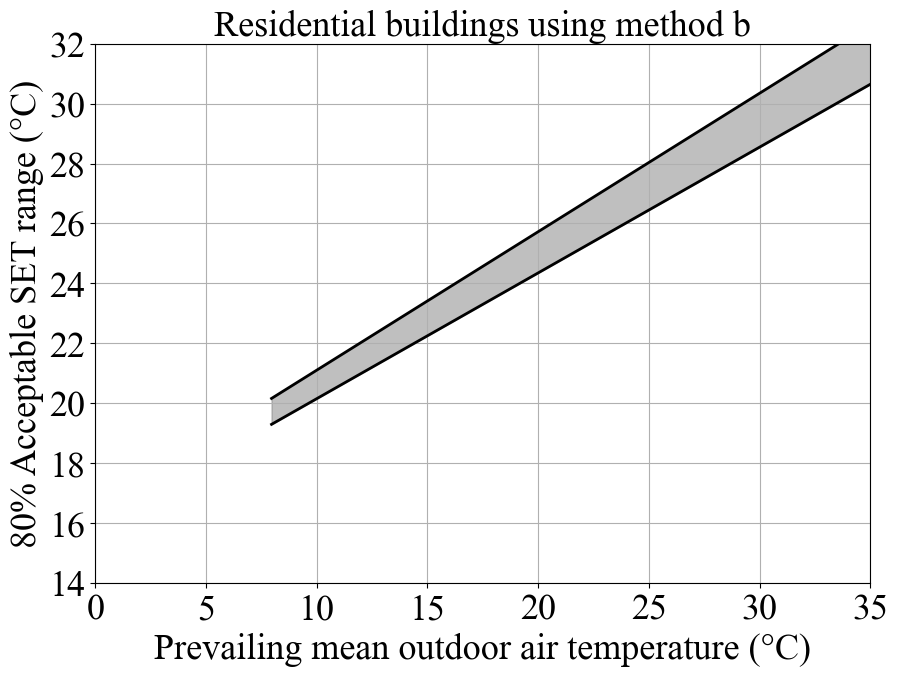

In [43]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_re_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable SET range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Residential buildings using method b', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)

